# ASHRAE - Great Energy Predictor III
https://www.kaggle.com/competitions/ashrae-energy-prediction/overview

LightGBMをやってみる  
参考  
https://www.kaggle.com/code/aitude/ashrae-kfold-lightgbm-without-leak-1-08  

https://www.kaggle.com/code/patrick0302/locate-cities-according-weather-temperature/notebook

LightGBM パラメーター内容  
https://zenn.dev/mosamosa/articles/07d0076c9292136a3639

In [1]:
# 定数定義
DATA_PATH = "./data"
""" データディレクトリ """

' データディレクトリ '

In [9]:
# インポート定義

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import datetime
from dateutil import tz
import gc
import os
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

In [32]:
# データ読み込み
train_df = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))

# Remove outliers
# TODO:なぜこの条件で除外しているかの確認が必要
train_df = train_df [ train_df['building_id'] != 1099 ]
train_df = train_df.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

building_df = pd.read_csv(os.path.join(DATA_PATH, 'building_metadata.csv'))
weather_df = pd.read_csv(os.path.join(DATA_PATH, 'weather_train.csv'))

In [24]:
def convert_timezone(weather_df: pd.DataFrame) -> pd.DataFrame:
  """気象データの観測日時をサイト毎の現地日時へ変換する

  Args:
      weather_df (pd.DataFrame): 気象データ

  Returns:
      pd.DataFrame: 観測日時のタイムゾーン変換後のデータを返す
  """
  # タイムゾーン定義
  UTC = tz.gettz("UTC") # 標準時
  EST = tz.gettz('EST') # 東部標準時
  EDT = tz.gettz('EDT') # 東部夏時間
  PST = tz.gettz('PST') # 太平洋標準時
  PDT = tz.gettz('PDT') # 太平洋夏時間
  CST = tz.gettz('CST') # 中部標準時
  CDT = tz.gettz('CDT') # 中部夏時間

  # タイムゾーン設定
  local_timezone_dict = {
    0: EST, # アメリカ フロリダ州 ジャクソンビル
    1: UTC, # イングランド ロンドン
    2: EST, # アメリカ フロリダ州 フェニックス
    3: EST, # アメリカ ペンシルベニア州 フィラデルフィア
    4: PST, # アメリカ カリフォルニア州 サンフランシスコ
    5: UTC, # イングランド ラフバラー
    6: EST, # アメリカ ペンシルベニア州 フィラデルフィア
    7: EST, # カナダ ケベック州 モントリオール
    8: EST, # アメリカ フロリダ州 ジャクソンビル
    9: CST, # アメリカ テキサス州 サンアントニオ
    10: PST, # アメリカ ネバダ州 ラスベガス
    11: EST, # カナダ ケベック州 モントリオール
    12: UTC, # アイルランド ダブリン
    13: CST, # アメリカ ミネソタ州 ミネアポリス
    14: EST, # アメリカ ペンシルベニア州 フィラデルフィア
    15: EST, # アメリカ ペンシルベニア州 ピッツバーグ
  }

  # サマータイムゾーン設定
  summer_timezone_dict = {
    0: EDT, # アメリカ フロリダ州 ジャクソンビル
    3: EDT, # アメリカ ペンシルベニア州 フィラデルフィア
    4: PDT, # アメリカ カリフォルニア州 サンフランシスコ
    6: EDT, # アメリカ ペンシルベニア州 フィラデルフィア
    7: EDT, # カナダ ケベック州 モントリオール
    8: EDT, # アメリカ フロリダ州 ジャクソンビル
    9: CDT, # アメリカ テキサス州 サンアントニオ
    10: PDT, # アメリカ ネバダ州 ラスベガス
    11: EDT, # カナダ ケベック州 モントリオール
    13: CDT, # アメリカ ミネソタ州 ミネアポリス
    14: EDT, # アメリカ ペンシルベニア州 フィラデルフィア
    15: EDT, # アメリカ ペンシルベニア州 ピッツバーグ
  }

  # サマータイム 適用日時
  summer_time_start_timestamp = datetime.datetime(2016, 3, 12, 20, 0, 0, tzinfo=UTC)
  summer_time_end_timestamp = datetime.datetime(2016, 11, 5, 20, 0, 0, tzinfo=UTC)

  datetime_df = pd.DataFrame(data=weather_df, columns=["site_id", "timestamp"]) 
  datetime_df["datetime"] = pd.to_datetime(datetime_df["timestamp"], utc=True)
  datetime_df["original_datetime"] = datetime_df["datetime"]
  datetime_df["conv_timestamp"] = datetime_df["timestamp"]

  for siteId, timezone in local_timezone_dict.items():
    # タイムゾーン変換
    update_datetime_df = datetime_df[datetime_df["site_id"] == siteId]
    update_datetime_df["datetime"] = update_datetime_df["original_datetime"].dt.tz_convert(timezone)
  
    # 元の文字列フォーマットへ戻す
    update_datetime_df["conv_timestamp"] = update_datetime_df["datetime"].dt.strftime("%Y-%m-%d %H:%M:%S")

    # サマータイム変換 ※TODO:うまくいってない？
    if (siteId in summer_timezone_dict) :
      # タイムゾーン変換
      summer_timezone = summer_timezone_dict[siteId]
      summer_time_datetime_df = update_datetime_df[(update_datetime_df["original_datetime"] >= summer_time_start_timestamp) & (update_datetime_df["original_datetime"]  <= summer_time_end_timestamp)]
      summer_time_datetime_df["datetime"] = summer_time_datetime_df["original_datetime"].dt.tz_convert(summer_timezone)
      
      # 元の文字列フォーマットへ戻す
      summer_time_datetime_df["conv_timestamp"] = summer_time_datetime_df["datetime"].dt.strftime("%Y-%m-%d %H:%M:%S")
      
      update_datetime_df.update(summer_time_datetime_df, overwrite=True)
    
    datetime_df.update(update_datetime_df, overwrite=True)

  datetime_df["timestamp"] = datetime_df["conv_timestamp"]
  datetime_df.drop(["datetime", "original_datetime", "conv_timestamp"], axis=1)

  weather_df.update(datetime_df, overwrite=True)
  return weather_df
  

In [29]:
# Original code from https://www.kaggle.com/aitude/ashrae-missing-weather-data-handling by @aitude

def fill_weather_dataset(weather_df: pd.DataFrame) -> pd.DataFrame:
    """気象データの欠損値を補完する

    Args:
        weather_df (pd.DataFrame): 気象データ

    Returns:
        pd.DataFrame: データ補完後の気象データを返す
    """
    # サイトIDの数
    SITE_ID_COUNT = 16

    # 気象データの観測時間リストを作成
    time_format = "%Y-%m-%d %H:%M:%S"
    start_date = datetime.datetime.strptime(weather_df['timestamp'].min(),time_format)
    end_date = datetime.datetime.strptime(weather_df['timestamp'].max(),time_format)
    total_hours = int(((end_date - start_date).total_seconds() + 3600) / 3600)
    hours_list = [(end_date - datetime.timedelta(hours=x)).strftime(time_format) for x in range(total_hours)]

    # サイト毎に欠損データを追加
    # ※追加するデータの値はnanを設定
    for site_id in range(SITE_ID_COUNT):
        site_hours = np.array(weather_df[weather_df['site_id'] == site_id]['timestamp'])
        new_rows = pd.DataFrame(np.setdiff1d(hours_list,site_hours),columns=['timestamp'])
        new_rows['site_id'] = site_id
        weather_df = pd.concat([weather_df,new_rows])

        weather_df = weather_df.reset_index(drop=True)

    # 観測日時より、日、週、月のカラムを作成
    # ※後述の追加カラムのため
    weather_df["datetime"] = pd.to_datetime(weather_df["timestamp"])
    weather_df["day"] = weather_df["datetime"].dt.day
    weather_df["week"] = weather_df["datetime"].dt.week
    weather_df["month"] = weather_df["datetime"].dt.month

    # 欠損値を補完    
    # データ集計の高速化のため、集計単位でインデックスを作成
    weather_df = weather_df.set_index(['site_id','day','month'])

    # 気温
    air_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['air_temperature'].mean(),columns=["air_temperature"])
    weather_df.update(air_temperature_filler,overwrite=False)

    # 雲量
    # Step 1 グループ毎の平均値を取得
    cloud_coverage_filler = weather_df.groupby(['site_id','day','month'])['cloud_coverage'].mean()
    # Step 2 直前に値が設定されている場合、その値を使用する
    cloud_coverage_filler = pd.DataFrame(cloud_coverage_filler.fillna(method='ffill'),columns=["cloud_coverage"])

    weather_df.update(cloud_coverage_filler,overwrite=False)

    # 露点温度(≒湿度)
    dew_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['dew_temperature'].mean(),columns=["dew_temperature"])
    weather_df.update(dew_temperature_filler, overwrite=False)

    # 海面気圧
    # Step 1 グループ毎の平均値を取得
    sea_level_filler = weather_df.groupby(['site_id','day','month'])['sea_level_pressure'].mean()
    # Step 2 直前に値が設定されている場合、その値を使用する
    sea_level_filler = pd.DataFrame(sea_level_filler.fillna(method='ffill'),columns=['sea_level_pressure'])

    weather_df.update(sea_level_filler,overwrite=False)

    # 風向き
    wind_direction_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_direction'].mean(),columns=['wind_direction'])
    weather_df.update(wind_direction_filler,overwrite=False)

    # 風速
    wind_speed_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_speed'].mean(),columns=['wind_speed'])
    weather_df.update(wind_speed_filler,overwrite=False)

    # 降水量
    # Step 1 グループ毎の平均値を取得
    precip_depth_filler = weather_df.groupby(['site_id','day','month'])['precip_depth_1_hr'].mean()
    # Step 2 直前に値が設定されている場合、その値を資料する
    precip_depth_filler = pd.DataFrame(precip_depth_filler.fillna(method='ffill'),columns=['precip_depth_1_hr'])

    weather_df.update(precip_depth_filler,overwrite=False)

    # 観測日時を現地時間へ変換する
    # weather_df = convert_timezone(weather_df)

    # インデックスを再作成し、欠損値補完用に追加したカラムを削除
    weather_df = weather_df.reset_index()
    weather_df = weather_df.drop(['datetime','day','week','month'],axis=1)

    return weather_df

In [26]:
# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin

def reduce_mem_usage(df: pd.DataFrame, use_float16: bool = False) -> pd.DataFrame:
    """ロードしたデータを型変換し、容量を削減する

    Args:
        df (pd.DataFrame): ロードデータ
        use_float16 (bool, optional): float16使用フラグ デフォルト値：False

    Returns:
        pd.DataFrame: 容量削減後のデータを返す
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [27]:
def features_engineering(df: pd.DataFrame) -> pd.DataFrame:
    """特徴量を作成する

    Args:
        df (pd.DataFrame): ロードしたデータ

    Returns:
        pd.DataFrame: 特徴量を追加したデータ
    """
    
    # 時系列順にソートする
    df.sort_values("timestamp")
    df.reset_index(drop=True)
    
    # Add more features
    # 日時
    df["timestamp"] = pd.to_datetime(df["timestamp"],format="%Y-%m-%d %H:%M:%S")
    
    # 時間
    df["hour"] = df["timestamp"].dt.hour
    
    # 曜日
    df["weekend"] = df["timestamp"].dt.weekday
    
    # 総床面積 ※logでは0が設定された場合に-∞になるため、log(1+a)にする
    df["square_feet"] = np.log1p(df["square_feet"])

    # 築年数 ※値が設定されている場合は"1"、その他の場合は"0"を設定
    df["year_built"] = np.where(df["year_built"].notna(), 1, 0)

    # 体感温度 ※風による温度影響を測るため、北風をマイナス値(冷たい風)、南風をプラス値(暖かい風)とし、風速を掛けた値を設定する
    df["wind_direction"] = -np.sin(np.radians(df["wind_direction"] % 360))
    df["wind_warn"] = df["wind_direction"] * df["wind_speed"]
    
    # 使用しないカラムを削除する
    drop = ["timestamp","sea_level_pressure", "wind_direction", "wind_speed", "floor_count", "building_id"]
    df = df.drop(drop, axis=1)
    gc.collect()
    
    # Encode Categorical Data
    le = LabelEncoder()
    df["primary_use"] = le.fit_transform(df["primary_use"])
    
    return df

In [33]:
# 気象データの欠損値を補完する
weather_df = fill_weather_dataset(weather_df)
weather_df = convert_timezone(weather_df)

/var/folders/km/rlhv761j4rqcrksj6ch5bw_r0000gn/T/ipykernel_8230/4205743041.py:36: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  weather_df["week"] = weather_df["datetime"].dt.week
/var/folders/km/rlhv761j4rqcrksj6ch5bw_r0000gn/T/ipykernel_8230/890867776.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  update_datetime_df["datetime"] = update_datetime_df["original_datetime"].dt.tz_convert(timezone)
/var/folders/km/rlhv761j4rqcrksj6ch5bw_r0000gn/T/ipykernel_8230/890867776.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [34]:
# データ容量を削減する
train_df = reduce_mem_usage(train_df,use_float16=True)
building_df = reduce_mem_usage(building_df,use_float16=True)
weather_df = reduce_mem_usage(weather_df,use_float16=True)

Memory usage of dataframe is 757.31 MB
Memory usage after optimization is: 322.18 MB
Decreased by 57.5%
Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.02 MB
Decreased by 73.9%
Memory usage of dataframe is 9.65 MB
Memory usage after optimization is: 2.73 MB
Decreased by 71.7%


In [35]:
# コーディング用にロード、加工したデータを保存する
# TODO:テストコードのため、要削除
# train_df.to_pickle(os.path.join(DATA_PATH, "train_df.pkl"))
# building_df.to_pickle(os.path.join(DATA_PATH, "building_df.pkl"))
# weather_df.to_pickle(os.path.join(DATA_PATH, "weather_df.pkl"))
weather_df.to_pickle(os.path.join(DATA_PATH, "weather_df2.pkl"))

In [28]:
# コーディング用に保存したデータをロードする
# TODO:テストコードのため、要削除
train_df = pd.read_pickle(os.path.join(DATA_PATH, "train_df.pkl"))
building_df = pd.read_pickle(os.path.join(DATA_PATH, "building_df.pkl"))
weather_df = pd.read_pickle(os.path.join(DATA_PATH, "weather_df.pkl"))
# weather_df = pd.read_pickle(os.path.join(DATA_PATH, "weather_df.pk2"))

In [36]:
# 各データを結合する
train_df = train_df.merge(building_df, left_on='building_id',right_on='building_id',how='left')
# train_df = train_df.merge(weather_df,how='left',left_on=['site_id','timestamp'],right_on=['site_id', 'timestamp'])
train_df = train_df.merge(weather_df,how='inner',left_on=['site_id','timestamp'],right_on=['site_id', 'timestamp'])
del weather_df
gc.collect()

0

In [37]:
# 特徴量を作成する
train_df = features_engineering(train_df)

In [38]:
# データを目的変数と特徴量変数に分割する
target = np.log1p(train_df["meter_reading"])
features = train_df.drop("meter_reading", axis = 1)
del train_df
gc.collect()

15

In [39]:
# カテゴリ変数リスト
categorical_features = ["site_id", "meter", "primary_use", "hour", "weekend", "year_built"]

# パラメーター設定
params = {
    "objective": "regression", # 目的関数：回帰
    "boosting": "gbdt", # 勾配ブースティング
    # "seed": 314, #シード値
    "num_leaves": 62, # 決定木の端末ノードの数
    #"max_depth": 7, #決定木の深さ
    "learning_rate": 0.05, # 学習率
    "feature_fraction": 0.85, # 特徴量の削減率 ※1未満の場合、特徴量を削減して学習される
    "reg_lambda": 2, # L2正則化項の係数 ※過学習を防ぐために用いる関数のパラメータ
    "metric": "rmse",# モデルの性能を測る指標 ※二乗平均平方根誤差
    "force_row_wise": True, # 行ベースのヒストグラムを生成する
    "verbose": -1
}

# シード値｀
seeds = [314, 2801, 3532]

earlyStoppingcallback = early_stopping(50)
logEvaluationCallback = log_evaluation(25)

# 学習実行
cnt = 0
kf = KFold(n_splits=3)
models = []
for train_index, test_index in kf.split(features):
    train_features = features.loc[train_index]
    train_target = target.loc[train_index]
    
    test_features = features.loc[test_index]
    test_target = target.loc[test_index]

    # データセット作成    
    d_training = lgb.Dataset(train_features, label=train_target, free_raw_data=False)
    d_test = lgb.Dataset(test_features, label=test_target, free_raw_data=False)
    
    params["seed"] = seeds[cnt]

    # 学習実行
    model = lgb.train(
        params,
        train_set=d_training,
        num_boost_round=1000,
        valid_sets=[d_training, d_test],
        categorical_feature=categorical_features,
        callbacks=[
            earlyStoppingcallback,
            logEvaluationCallback
        ]
    )
    
    models.append(model)
    cnt += 1
    
    del train_features, train_target, test_features, test_target, d_training, d_test
    gc.collect()

/opt/homebrew/Caskroom/miniforge/base/envs/python_3.10/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['hour', 'meter', 'primary_use', 'site_id', 'weekend', 'year_built']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/homebrew/Caskroom/miniforge/base/envs/python_3.10/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/homebrew/Caskroom/miniforge/base/envs/python_3.10/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.5656	valid_1's rmse: 1.61327
[50]	training's rmse: 1.40557	valid_1's rmse: 1.45883
[75]	training's rmse: 1.33249	valid_1's rmse: 1.39739
[100]	training's rmse: 1.28784	valid_1's rmse: 1.3575
[125]	training's rmse: 1.25717	valid_1's rmse: 1.33323
[150]	training's rmse: 1.22977	valid_1's rmse: 1.31174
[175]	training's rmse: 1.20841	valid_1's rmse: 1.296
[200]	training's rmse: 1.19012	valid_1's rmse: 1.28212
[225]	training's rmse: 1.17389	valid_1's rmse: 1.2706
[250]	training's rmse: 1.15474	valid_1's rmse: 1.25805
[275]	training's rmse: 1.14247	valid_1's rmse: 1.25152
[300]	training's rmse: 1.12945	valid_1's rmse: 1.24361
[325]	training's rmse: 1.11565	valid_1's rmse: 1.23572
[350]	training's rmse: 1.10583	valid_1's rmse: 1.23038
[375]	training's rmse: 1.09439	valid_1's rmse: 1.22466
[400]	training's rmse: 1.08421	valid_1's rmse: 1.22038
[425]	training's rmse: 1.07335	valid_1's rmse: 1.21437
[450]	traini

/opt/homebrew/Caskroom/miniforge/base/envs/python_3.10/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['hour', 'meter', 'primary_use', 'site_id', 'weekend', 'year_built']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/homebrew/Caskroom/miniforge/base/envs/python_3.10/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/homebrew/Caskroom/miniforge/base/envs/python_3.10/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[25]	training's rmse: 1.52705	valid_1's rmse: 1.61669
[50]	training's rmse: 1.36953	valid_1's rmse: 1.48957
[75]	training's rmse: 1.29949	valid_1's rmse: 1.42715
[100]	training's rmse: 1.26245	valid_1's rmse: 1.39036
[125]	training's rmse: 1.23276	valid_1's rmse: 1.36709
[150]	training's rmse: 1.21145	valid_1's rmse: 1.34562
[175]	training's rmse: 1.19169	valid_1's rmse: 1.32829
[200]	training's rmse: 1.17444	valid_1's rmse: 1.31298
[225]	training's rmse: 1.15858	valid_1's rmse: 1.29924
[250]	training's rmse: 1.144	valid_1's rmse: 1.28717
[275]	training's rmse: 1.12942	valid_1's rmse: 1.27324
[300]	training's rmse: 1.12042	valid_1's rmse: 1.2648
[325]	training's rmse: 1.10947	valid_1's rmse: 1.25563
[350]	training's rmse: 1.099	valid_1's rmse: 1.24795
[375]	training's rmse: 1.09153	valid_1's rmse: 1.2414
[400]	training's rmse: 1.08471	valid_1's rmse: 1.23463
[425]	training's rmse: 1.07633	valid_1's rmse: 1.22441
[450]	training's rmse: 1.06749	valid_1's rmse: 1.2153
[475]	training's rms

/opt/homebrew/Caskroom/miniforge/base/envs/python_3.10/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['hour', 'meter', 'primary_use', 'site_id', 'weekend', 'year_built']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/homebrew/Caskroom/miniforge/base/envs/python_3.10/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/homebrew/Caskroom/miniforge/base/envs/python_3.10/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[25]	training's rmse: 1.54868	valid_1's rmse: 1.56872
[50]	training's rmse: 1.40133	valid_1's rmse: 1.44077
[75]	training's rmse: 1.32613	valid_1's rmse: 1.38467
[100]	training's rmse: 1.27643	valid_1's rmse: 1.35037
[125]	training's rmse: 1.24161	valid_1's rmse: 1.33029
[150]	training's rmse: 1.2157	valid_1's rmse: 1.31307
[175]	training's rmse: 1.18865	valid_1's rmse: 1.29877
[200]	training's rmse: 1.16681	valid_1's rmse: 1.28568
[225]	training's rmse: 1.14879	valid_1's rmse: 1.27673
[250]	training's rmse: 1.13386	valid_1's rmse: 1.26929
[275]	training's rmse: 1.11891	valid_1's rmse: 1.26264
[300]	training's rmse: 1.10549	valid_1's rmse: 1.2573
[325]	training's rmse: 1.09351	valid_1's rmse: 1.25185
[350]	training's rmse: 1.08266	valid_1's rmse: 1.24847
[375]	training's rmse: 1.06916	valid_1's rmse: 1.2409
[400]	training's rmse: 1.05817	valid_1's rmse: 1.2363
[425]	training's rmse: 1.04929	valid_1's rmse: 1.23229
[450]	training's rmse: 1.03984	valid_1's rmse: 1.22961
[475]	training's 

In [40]:
# メモリ解放
del features, target
gc.collect()

15

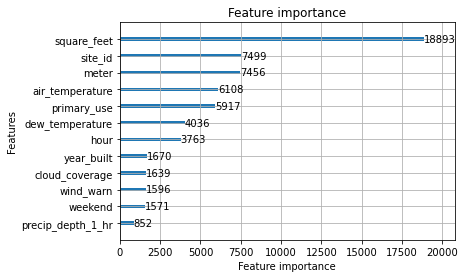

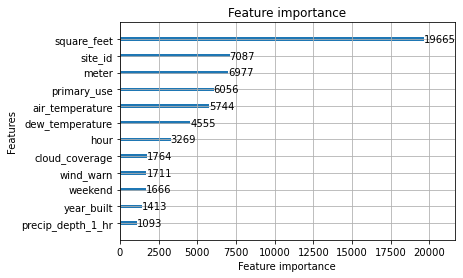

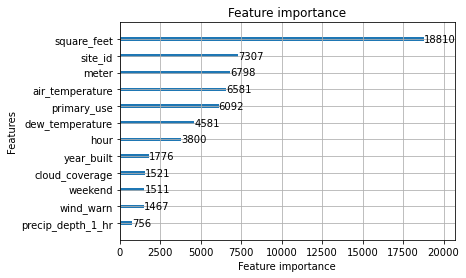

In [41]:
# 学習結果をプロット
for model in models:
    lgb.plot_importance(model)
    plt.show()
    # lgb.create_tree_digraph(model)

In [42]:
# テストデータ読み込み
test_df = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
row_ids = test_df["row_id"]
test_df.drop("row_id", axis=1, inplace=True)
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 954.38 MB
Memory usage after optimization is: 199.47 MB
Decreased by 79.1%


In [ ]:
# コーディング用にロード、加工したデータを保存する
# TODO:テストコードのため、要削除
# test_df.to_pickle(os.path.join(DATA_PATH, "test_df.pkl"))

In [14]:
# コーディング用に保存したデータをロードする
# TODO:テストコードのため、要削除
test_df = pd.read_pickle(os.path.join(DATA_PATH, "test_df.pkl"))

In [45]:
# ビルデータを結合
test_df = test_df.merge(building_df,left_on='building_id',right_on='building_id',how='left')
del building_df
gc.collect()

969

In [43]:
# テスト気象データ読み込み、データを結合
weather_train_df = pd.read_csv(os.path.join(DATA_PATH, 'weather_train.csv'))
weather_test_df = pd.read_csv(os.path.join(DATA_PATH, 'weather_test.csv'))
weather_df = pd.concat([weather_train_df, weather_test_df])
# weather_df = pd.read_csv(os.path.join(DATA_PATH, 'weather_test.csv'))
weather_df = fill_weather_dataset(weather_df)
weather_df = convert_timezone(weather_df)
weather_df = reduce_mem_usage(weather_df)

del weather_train_df, weather_test_df

/var/folders/km/rlhv761j4rqcrksj6ch5bw_r0000gn/T/ipykernel_8230/4205743041.py:36: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  weather_df["week"] = weather_df["datetime"].dt.week
/var/folders/km/rlhv761j4rqcrksj6ch5bw_r0000gn/T/ipykernel_8230/890867776.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  update_datetime_df["datetime"] = update_datetime_df["original_datetime"].dt.tz_convert(timezone)
/var/folders/km/rlhv761j4rqcrksj6ch5bw_r0000gn/T/ipykernel_8230/890867776.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

Memory usage of dataframe is 28.90 MB
Memory usage after optimization is: 14.86 MB
Decreased by 48.6%


In [ ]:
# コーディング用にロード、加工したデータを保存する
# TODO:テストコードのため、要削除
# weather_df.to_pickle(os.path.join(DATA_PATH, "weather_test_df.pkl"))

In [15]:
# コーディング用に保存したデータをロードする
# TODO:テストコードのため、要削除
weather_df = pd.read_pickle(os.path.join(DATA_PATH, "weather_test_df.pkl"))

In [46]:
# 気象データをテストデータへ結合
test_df = test_df.merge(weather_df,how='left',on=['timestamp','site_id'])
del weather_df
gc.collect()

15

In [47]:
# 特徴量を作成する
test_df = features_engineering(test_df)

/opt/homebrew/Caskroom/miniforge/base/envs/python_3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sin
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [48]:
# 推定する
results = []
for model in models:
    if  results == []:
        results = np.expm1(model.predict(test_df, num_iteration=model.best_iteration)) / len(models)
    else:
        results += np.expm1(model.predict(test_df, num_iteration=model.best_iteration)) / len(models)
    # del model
    gc.collect()

/var/folders/km/rlhv761j4rqcrksj6ch5bw_r0000gn/T/ipykernel_8230/3602265000.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if  results == []:


In [49]:
# データ、モデル削除
del test_df, models
gc.collect()

0

In [50]:
# 提出データ作成
results_df = pd.DataFrame({"row_id": row_ids, "meter_reading": np.clip(results, 0, a_max=None)})
del row_ids,results
gc.collect()
results_df.to_csv("submission.csv", index=False)

In [24]:
results_df.head(20)

,row_id,meter_reading
0,0,123.849259
1,1,62.940305
2,2,9.525832
3,3,237.300438
4,4,1260.965857
5,5,62.410361
6,6,116.221314
7,7,592.043077
8,8,397.530478
9,9,307.365620


In [51]:
# 推定結果を提出
!kaggle competitions submit  -f submission.csv -m "lightGBMを用いて推定 5回目提出 気象データの観測日時を各サイトの現地時間に変換して紐づけるように修正" ashrae-energy-prediction

100%|██████████████████████████████████████| 1.05G/1.05G [06:18<00:00, 2.99MB/s]
Successfully submitted to ASHRAE - Great Energy Predictor III

---

以下、テストコード

In [ ]:
# データ差異を確認
tmp_weather_df.merge(weather_df, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', 1)

/var/folders/km/rlhv761j4rqcrksj6ch5bw_r0000gn/T/ipykernel_19513/2116604713.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  tmp_weather_df.merge(weather_df, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', 1)


,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
139773,1,2016-02-15 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
139774,1,2016-02-15 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
139775,1,2016-02-15 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
139776,1,2016-02-15 17:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
139777,1,2016-02-15 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
140539,15,2016-12-09 10:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
140540,15,2016-12-17 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
140541,15,2016-12-20 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
140542,15,2016-12-24 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:

np.log1p(0)

0.0

In [ ]:
# 風向きが0のデータは風速が0のデータであることを確認
weather_df.query("wind_direction == 0 and wind_speed != 0")

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed


In [65]:
from matplotlib import pyplot

def plotMeterByYearBuilt(df: pd.DataFrame) -> None :
    """建築年とメーター値の散布図を作成する

    Args:
        df (pd.DataFrame): データ
    """
    
    fig, axes = pyplot.subplots(nrows=4, ncols=1, sharex=False)

    cnt = 0
    for ctg in [0, 1, 2 ,3]:
      plotDf = df.query(f"meter == {ctg}")
      axes[cnt].scatter(plotDf["year_built"], plotDf["meter_reading"])
      
      cnt += 1
      del plotDf
    
    fig.tight_layout()
    plt.show()


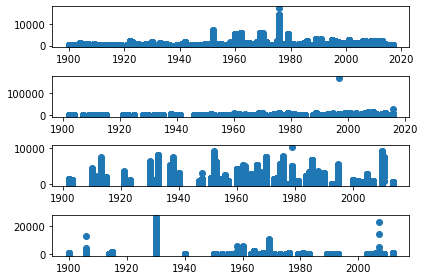

In [ ]:
# 建築年数は直接関係しない模様
plotMeterByYearBuilt(train_df)

In [69]:
from matplotlib import pyplot

def meterMeanByYearBuilt(df: pd.DataFrame) -> None :
    """メーター値の平均値を築年の設定有無毎に算出する

    Args:
        df (pd.DataFrame): データ
    """

    for ctg in [0, 1, 2 ,3]:
      yearBuiltSetDf = df.query(f"meter == {ctg} and year_built == year_built")
      yearBuiltNotSetDf = df.query(f"meter == {ctg} and year_built != year_built")

      yearBuiltSetMean =yearBuiltSetDf["meter_reading"].mean()
      yearBuiltNotSetMean =yearBuiltNotSetDf["meter_reading"].mean()

      print(f"Category: {ctg}")  
      print(f"YearBuiltSetMean: {yearBuiltSetMean}")  
      print(f"YearBuiltNotSetMean: {yearBuiltNotSetMean}")  
      
      del yearBuiltSetDf, yearBuiltNotSetDf, yearBuiltSetMean, yearBuiltNotSetMean
    

In [74]:
meterMeanByYearBuilt(train_df)

Category: 0
YearBuiltSetMean: 209.427490234375
YearBuiltNotSetMean: 148.044677734375
Category: 1
YearBuiltSetMean: 534.3399658203125
YearBuiltNotSetMean: 681.2288818359375
Category: 2
YearBuiltSetMean: 782.62548828125
YearBuiltNotSetMean: 1715.304931640625
Category: 3
YearBuiltSetMean: 186.57418823242188
YearBuiltNotSetMean: 547.9810180664062


In [75]:
from matplotlib import pyplot

def plotMeterByYearBuiltSet(df: pd.DataFrame) -> None :
    """建築年とメーター値の散布図を作成する

    Args:
        df (pd.DataFrame): データ
    """
    
    fig, axes = pyplot.subplots(nrows=4, ncols=2, sharex=False)

    cnt = 0
    for ctg in [0, 1, 2 ,3]:
      yearBuiltSetDf = df.query(f"meter == {ctg} and year_built == year_built")
      yearBuiltNotSetDf = df.query(f"meter == {ctg} and year_built != year_built")

      axes[cnt, 0].hist(yearBuiltSetDf["meter_reading"])
      axes[cnt, 1].hist(yearBuiltNotSetDf["meter_reading"])
      
      cnt += 1
      del yearBuiltSetDf, yearBuiltNotSetDf
    
    fig.tight_layout()
    plt.show()


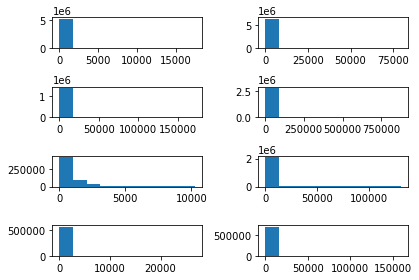

In [76]:
plotMeterByYearBuiltSet(train_df)

In [79]:
def meterStaticsByYearBuilt(df: pd.DataFrame) -> None :
    for ctg in [0, 1, 2 ,3]:
      yearBuiltSetDf = df.query(f"meter == {ctg} and year_built == year_built")
      yearBuiltNotSetDf = df.query(f"meter == {ctg} and year_built != year_built")
      print(f"Category: {ctg}")  
      print(f"YearBuiltSet")
      print(yearBuiltSetDf["meter_reading"].describe())
      print(f"YearBuiltNotSet")
      print(yearBuiltNotSetDf["meter_reading"].describe())
      
      del yearBuiltSetDf, yearBuiltNotSetDf
    

In [81]:
meterStaticsByYearBuilt(train_df)

Category: 0
YearBuiltSet
count    5.244763e+06
mean     2.094275e+02
std      4.735475e+02
min      0.000000e+00
25%      2.307000e+01
50%      7.810000e+01
75%      1.991750e+02
max      1.750210e+04
Name: meter_reading, dtype: float64
YearBuiltNotSet
count    6.461253e+06
mean     1.480447e+02
std      2.917258e+02
min      0.000000e+00
25%      2.131500e+01
50%      5.891670e+01
75%      1.553000e+02
max      7.976900e+04
Name: meter_reading, dtype: float64
Category: 1
YearBuiltSet
count    1.362881e+06
mean     5.343400e+02
std      1.216988e+03
min      0.000000e+00
25%      1.654710e+01
50%      1.074800e+02
75%      4.221040e+02
max      1.726110e+05
Name: meter_reading, dtype: float64
YearBuiltNotSet
count    2.819559e+06
mean     6.812289e+02
std      9.691904e+03
min      0.000000e+00
25%      7.631600e+00
50%      1.270000e+02
75%      4.833910e+02
max      8.803740e+05
Name: meter_reading, dtype: float64
Category: 2
YearBuiltSet
count    567697.000000
mean        782.625488

In [27]:
np.unique(train_df.site_id)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
      dtype=int8)

In [94]:
# 標準時
UTC = tz.gettz("UTC")

# 東部標準時
EST = tz.gettz('EST')

# 東部夏時間
EDT = tz.gettz('EDT')

# 太平洋標準時
PST = tz.gettz('PST')

# 太平洋夏じかん
PDT = tz.gettz('PDT')

# 中部標準時
CST = tz.gettz('CST')

# 中部夏時間
CDT = tz.gettz('CDT')

# タイムゾーン設定
local_timezone_dict = {
  0: EST, # アメリカ フロリダ州 ジャクソンビル
  1: UTC, # イングランド ロンドン
  2: EST, # アメリカ フロリダ州 フェニックス
  3: EST, # アメリカ ペンシルベニア州 フィラデルフィア
  4: PST, # アメリカ カリフォルニア州 サンフランシスコ
  5: UTC, # イングランド ラフバラー
  6: EST, # アメリカ ペンシルベニア州 フィラデルフィア
  7: EST, # カナダ ケベック州 モントリオール
  8: EST, # アメリカ フロリダ州 ジャクソンビル
  9: CST, # アメリカ テキサス州 サンアントニオ
  10: PST, # アメリカ ネバダ州 ラスベガス
  11: EST, # カナダ ケベック州 モントリオール
  12: UTC, # アイルランド ダブリン
  13: CST, # アメリカ ミネソタ州 ミネアポリス
  14: EST, # アメリカ ペンシルベニア州 フィラデルフィア
  15: EST, # アメリカ ペンシルベニア州 ピッツバーグ
}

# サマータイムゾーン設定｀
summer_timezone_dict = {
  0: EDT, # アメリカ フロリダ州 ジャクソンビル
  3: EDT, # アメリカ ペンシルベニア州 フィラデルフィア
  4: PDT, # アメリカ カリフォルニア州 サンフランシスコ
  6: EDT, # アメリカ ペンシルベニア州 フィラデルフィア
  7: EDT, # カナダ ケベック州 モントリオール
  8: EDT, # アメリカ フロリダ州 ジャクソンビル
  9: CDT, # アメリカ テキサス州 サンアントニオ
  10: PDT, # アメリカ ネバダ州 ラスベガス
  11: EDT, # カナダ ケベック州 モントリオール
  13: CDT, # アメリカ ミネソタ州 ミネアポリス
  14: EDT, # アメリカ ペンシルベニア州 フィラデルフィア
  15: EDT, # アメリカ ペンシルベニア州 ピッツバーグ
}

# サマータイム 適用日時
summer_time_start_timestamp = datetime(2016, 3, 12, 20, 0, 0, tzinfo=UTC)
summer_time_end_timestamp = datetime(2016, 11, 5, 20, 0, 0, tzinfo=UTC)

weather_df["datetime"] = pd.to_datetime(weather_df["timestamp"], utc=True)
weather_df["original_datetime"] = weather_df["datetime"]
weather_df["conv_timestamp"] = weather_df["timestamp"]
datetime_df = pd.DataFrame(data=weather_df, columns=["site_id", "datetime", "original_datetime", "conv_timestamp"]) 

for siteId, timezone in local_timezone_dict.items():
  # タイムゾーン変換
  update_datetime_df = datetime_df[datetime_df["site_id"] == siteId]
  update_datetime_df["datetime"] = update_datetime_df["original_datetime"].dt.tz_convert(timezone)
  
  # 元の文字列フォーマットへ戻す
  update_datetime_df["conv_timestamp"] = update_datetime_df["datetime"].dt.strftime("%Y-%m-%d %H:%M:%S")

  
  # サマータイム変換
  if (siteId in summer_timezone_dict) :
    # タイムゾーン変換
    summer_timezone = summer_timezone_dict[siteId]
    summer_time_datetime_df = update_datetime_df[(update_datetime_df["original_datetime"] >= summer_time_start_timestamp) & (update_datetime_df["original_datetime"]  <= summer_time_end_timestamp)]
    summer_time_datetime_df["datetime"] = summer_time_datetime_df["original_datetime"].dt.tz_convert(summer_timezone)
    
    # 元の文字列フォーマットへ戻す
    summer_time_datetime_df["conv_timestamp"] = summer_time_datetime_df["datetime"].dt.strftime("%Y-%m-%d %H:%M:%S")
    
    update_datetime_df.update(summer_time_datetime_df, overwrite=True)
  
  datetime_df.update(update_datetime_df, overwrite=True)

datetime_df["timestamp"] = datetime_df["conv_timestamp"]
datetime_df.drop(["site_id", "datetime", "original_datetime", "conv_timestamp"], axis=1)

weather_df.update(datetime_df)


/var/folders/km/rlhv761j4rqcrksj6ch5bw_r0000gn/T/ipykernel_5037/614842603.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  update_datetime_df["datetime"] = update_datetime_df["original_datetime"].dt.tz_convert(timezone)
/var/folders/km/rlhv761j4rqcrksj6ch5bw_r0000gn/T/ipykernel_5037/614842603.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  update_datetime_df["conv_timestamp"] = update_datetime_df["datetime"].dt.strftime("%Y-%m-%d %H:%M:%S")
/var/folders/km/rlhv761j4rqcrksj6ch5bw_r0000gn/T/ipykernel

In [85]:
datetime_df[(datetime_df["original_datetime"] >= summer_time_start_timestamp) & (datetime_df["original_datetime"]  <= summer_time_end_timestamp)]

,site_id,datetime,original_datetime,conv_timestamp
1724,0.0,2016-03-12 15:00:00-05:00,2016-03-12 20:00:00+00:00,2016-03-12 15:00:00
1725,0.0,2016-03-12 16:00:00-05:00,2016-03-12 21:00:00+00:00,2016-03-12 16:00:00
1726,0.0,2016-03-12 17:00:00-05:00,2016-03-12 22:00:00+00:00,2016-03-12 17:00:00
1727,0.0,2016-03-12 18:00:00-05:00,2016-03-12 23:00:00+00:00,2016-03-12 18:00:00
1728,0.0,2016-03-12 19:00:00-05:00,2016-03-13 00:00:00+00:00,2016-03-12 19:00:00
...,...,...,...,...
140520,15.0,2016-11-02 08:00:00+00:00,2016-11-02 08:00:00+00:00,2016-11-02 08:00:00
140521,15.0,2016-11-02 09:00:00+00:00,2016-11-02 09:00:00+00:00,2016-11-02 09:00:00
140522,15.0,2016-11-02 10:00:00+00:00,2016-11-02 10:00:00+00:00,2016-11-02 10:00:00
140523,15.0,2016-11-03 03:00:00+00:00,2016-11-03 03:00:00+00:00,2016-11-03 03:00:00


In [67]:
print(update_datetime_df.replace())

0      2016-01-01 00:00:00+00:00
1      2016-01-01 01:00:00+00:00
2      2016-01-01 02:00:00+00:00
3      2016-01-01 03:00:00+00:00
4      2016-01-01 04:00:00+00:00
                  ...           
8779   2016-12-31 19:00:00+00:00
8780   2016-12-31 20:00:00+00:00
8781   2016-12-31 21:00:00+00:00
8782   2016-12-31 22:00:00+00:00
8783   2016-12-31 23:00:00+00:00
Name: datetime, Length: 8784, dtype: datetime64[ns, UTC]
